In [1]:
# import numpy, scipy, and matplotlib
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from itables import init_notebook_mode

init_notebook_mode(all_interactive=True)

from sklearn.model_selection import train_test_split


# import from scipy solve_ivp
from scipy.integrate import solve_ivp
import torch
%matplotlib widget

from ray import train, tune
from ray.train import Checkpoint, session, report
from ray.tune.schedulers import ASHAScheduler

import os
import tempfile

In [2]:
path = os.getcwd()
results_dir = os.path.join(path, "../tune")
os.makedirs(results_dir, exist_ok=True)

# Tuning of the PINN for the Damped Harmonic Oscillator ODE

In this notebook we tune the hyperparamenters of the PINN.

## Load data

In [3]:
# import data
# data are generated by "src/DHOscillator_data_gen.py"
data = np.load('../data/DHOscillator_data.npy')
data_X = data[:,0]
data_Y = data[:,1:]

In [4]:
def data_loader(X, Y, batch_size, grid_num):
    """
    Function to load data and divide it in batches, specific for
    PINN with grid_num, tunable number of point where enforce the ODE
    input: X, Y, batch_size, grid_num
    output: train_X_batches, train_Y_batches, val_X, val_Y, test_X, test_Y
    """

    # divide in train, validation and test
    train_frac = 0.7
    val_frac = 0.15
    test_frac = 0.15

    train_val_X = X[:int((train_frac+val_frac)*len(X))]
    train_val_Y = Y[:int((train_frac+val_frac)*len(X)), :]
    train_X, val_X, train_Y, val_Y = train_test_split(
        train_val_X, 
        train_val_Y, 
        test_size=val_frac/(train_frac+val_frac), 
        random_state=42
        )

    test_X = X[int((train_frac+val_frac)*len(X)):]
    test_Y = Y[int((train_frac+val_frac)*len(X)):, :]

    # dummy PINN dataset for train
    train_X = np.linspace(0, 30, grid_num)
    train_Y = np.zeros((grid_num, 2))

    # convert to torch tensor
    train_X = torch.tensor(train_X, dtype=torch.float32).view(-1, 1)
    train_Y = torch.tensor(train_Y, dtype=torch.float32)
    val_X = torch.tensor(val_X, dtype=torch.float32).view(-1, 1)
    val_Y = torch.tensor(val_Y, dtype=torch.float32)
    test_X = torch.tensor(test_X, dtype=torch.float32).view(-1, 1)
    test_Y = torch.tensor(test_Y, dtype=torch.float32)

    # divide in batches train
    train_X_batches = torch.split(train_X, batch_size)
    train_Y_batches = torch.split(train_Y, batch_size)

    
    return train_X_batches, train_Y_batches, val_X, val_Y, test_X, test_Y

## Define hyper model

In [5]:
#  define the model
class FFNN(torch.nn.Module):
    def __init__(self, n_layers, n_neurons):
        super(FFNN, self).__init__()
        layers = []
        for i in range(n_layers):
            if i == 0:
                layers.append(torch.nn.Linear(1, n_neurons))
            else:
                layers.append(torch.nn.Linear(n_neurons, n_neurons))
            layers.append(torch.nn.Tanh())
        layers.append(torch.nn.Linear(n_neurons, 2))
        self.model = torch.nn.Sequential(*layers)
    def forward(self, x):
        return self.model(x)

## Define the Objective

In [6]:
def objective(config):
    net = FFNN(config["n_layers"], config["n_neurons"])

    device = "cpu"

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=config["lr"])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        'min', 
        factor=config["factor"], 
        patience=config["patience"]
    )

    train_X_batches, train_Y_batches, val_X, val_Y, test_X, test_Y = data_loader(data_X, data_Y, config["batch_size"], config["grid_num"])

    for epoch in range(50000):
        for i, (X, Y) in enumerate(zip(train_X_batches, train_Y_batches)):
            optimizer.zero_grad()
            X.requires_grad = True
            Y_pred = net(X)

            # get the derivatives
            dx_dt = torch.autograd.grad(Y_pred[:,0], X, grad_outputs=torch.ones_like(Y_pred[:,0]), create_graph=True)[0]
            dv_dt = torch.autograd.grad(Y_pred[:,1], X, grad_outputs=torch.ones_like(Y_pred[:,1]), create_graph=True)[0]

            # loss_ode and loss_ic 
            loss_ode = torch.mean((dx_dt[:,0] - Y_pred[:,1])**2 + (dv_dt[:,0] + 0.1*Y_pred[:,1] + Y_pred[:,0])**2)
            loss_ic = ((Y_pred[0,0] - 1)**2 + (Y_pred[0,1] - 0)**2)

            loss = config["lambda"]*loss_ode + loss_ic
        
            loss.backward()
            optimizer.step()
            scheduler.step(loss)
                
        val_loss = criterion(net(val_X), val_Y).item()

        report(metrics={"loss": val_loss})

        if epoch % 100 == 0:
            torch.save(net.state_dict(), "./model.pth")

## Tuning

In [7]:
# configuration space and sampling method
config = {
    "n_layers": tune.randint(2, 6),
    "n_neurons": tune.randint(20, 40),
    "lr" : tune.loguniform(0.001, 0.01),
    "factor": tune.uniform(0.7, 0.99),
    "patience": tune.lograndint(100, 1000),
    "batch_size": tune.lograndint(100, 1000),
    "grid_num": tune.lograndint(100, 1000),
    "lambda" : tune.loguniform(10, 100)
}



# schedueler ASHA
scheduler = ASHAScheduler(
    metric="loss", 
    mode="min", 
    max_t=50000, 
    grace_period=7000, 
    reduction_factor=2
    )


tuner = tune.Tuner(
    objective,
    param_space=config,
    tune_config=tune.TuneConfig(
        num_samples=128,
        scheduler=scheduler,
    ),
    run_config=train.RunConfig(
        name="DHO_PINN_tuning",
        storage_path=results_dir
    )
)

In [8]:
results = tuner.fit()

2024-03-12 15:56:54,209	INFO tune.py:1042 -- Total run time: 8658.72 seconds (8651.95 seconds for the tuning loop).


In [9]:
df = results.get_dataframe()
df

loss   timestamp checkpoint_dir_name  done  training_iteration  \
0    0.000015  1710248027                None  True               50000   
1    0.091247  1710247179                None  True               14000   
2    0.178123  1710246995                None  True                7000   
3    0.181354  1710247955                None  True               50000   
4    0.144667  1710247080                None  True                7000   
..        ...         ...                 ...   ...                 ...   
123  0.175027  1710255092                None  True                7000   
124  0.157358  1710255262                None  True                7000   
125  0.185765  1710255140                None  True                7000   
126  0.082898  1710255341                None  True               14000   
127  0.177847  1710255407                None  True               28000   

        trial_id                 date  time_this_iter_s  time_total_s   pid  \
0    9b065_00000  2024-03-12_13-53-47          0.009690    467.900811  5326   
1    9b065_00001  2024-03-12_13-39-39          0.010300    167.088556  5329   
2    9b065_00002  2024-03-12_13-36-35          0.013086    103.356977  5330   
3    9b065_00003  2024-03-12_13-52-35          0.008222    410.339531  5334   
4    9b065_00004  2024-03-12_13-38-00          0.017785    173.733243  5335   
..           ...                  ...               ...           ...   ...   
123  9b065_00123  2024-03-12_15-51-32          0.049581    209.852490  5344   
124  9b065_00124  2024-03-12_15-54-22          0.039076    314.353094  5335   
125  9b065_00125  2024-03-12_15-52-20          0.013357    132.105762  5342   
126  9b065_00126  2024-03-12_15-55-41          0.014910    227.598845  5343   
127  9b065_00127  2024-03-12_15-56-47          0.003831    178.210384  5344   

     ... iterations_since_restore config/n_layers  config/n_neurons  \
0    ...                    50000               5                33   
1    ...                    14000               2                31   
2    ...                     7000               3                37   
3    ...                    50000               5                28   
4    ...                     7000               5                38   
..   ...                      ...             ...               ...   
123  ...                     7000               4                30   
124  ...                     7000               2                28   
125  ...                     7000               5                24   
126  ...                    14000               4                39   
127  ...                    28000               5                27   

     config/lr  config/factor  config/patience  config/batch_size  \
0     0.001432       0.739127              616                894   
1     0.001110       0.717738              479                319   
2     0.005881       0.730474              887                118   
3     0.006717       0.952166              174                315   
4     0.001437       0.826627              568                407   
..         ...            ...              ...                ...   
123   0.002230       0.953331              969                117   
124   0.008645       0.911701              270                115   
125   0.007100       0.810383              223                299   
126   0.007937       0.951226              102                624   
127   0.001029       0.930717              567                520   

     config/grid_num  config/lambda       logdir  
0                269      81.953152  9b065_00000  
1                389      40.088055  9b065_00001  
2                121      47.442912  9b065_00002  
3                127      16.297854  9b065_00003  
4                785      47.450846  9b065_00004  
..               ...            ...          ...  
123              368      16.457702  9b065_00123  
124              998      22.106460  9b065_00124  
125              5

In [ ]:
def get_alive_model(df, max_epoch):
    """
    Function to get the number of alive models at each epoch
    input: df, max_epoch
    output: alive_model
    """
    # get traininig_iteration vector
    training_iteration = df["training_iteration"]
    training_iteration = training_iteration.to_numpy()
    # alive_model = number of entries of training_iteration > epoch
    # epoch = (0, max_epoch)
    alive_model = np.zeros(max_epoch)
    for i in range(max_epoch):
        alive_model[i] = np.sum(training_iteration > i)
    return alive_model

alive_model = get_alive_model(df, 50000)

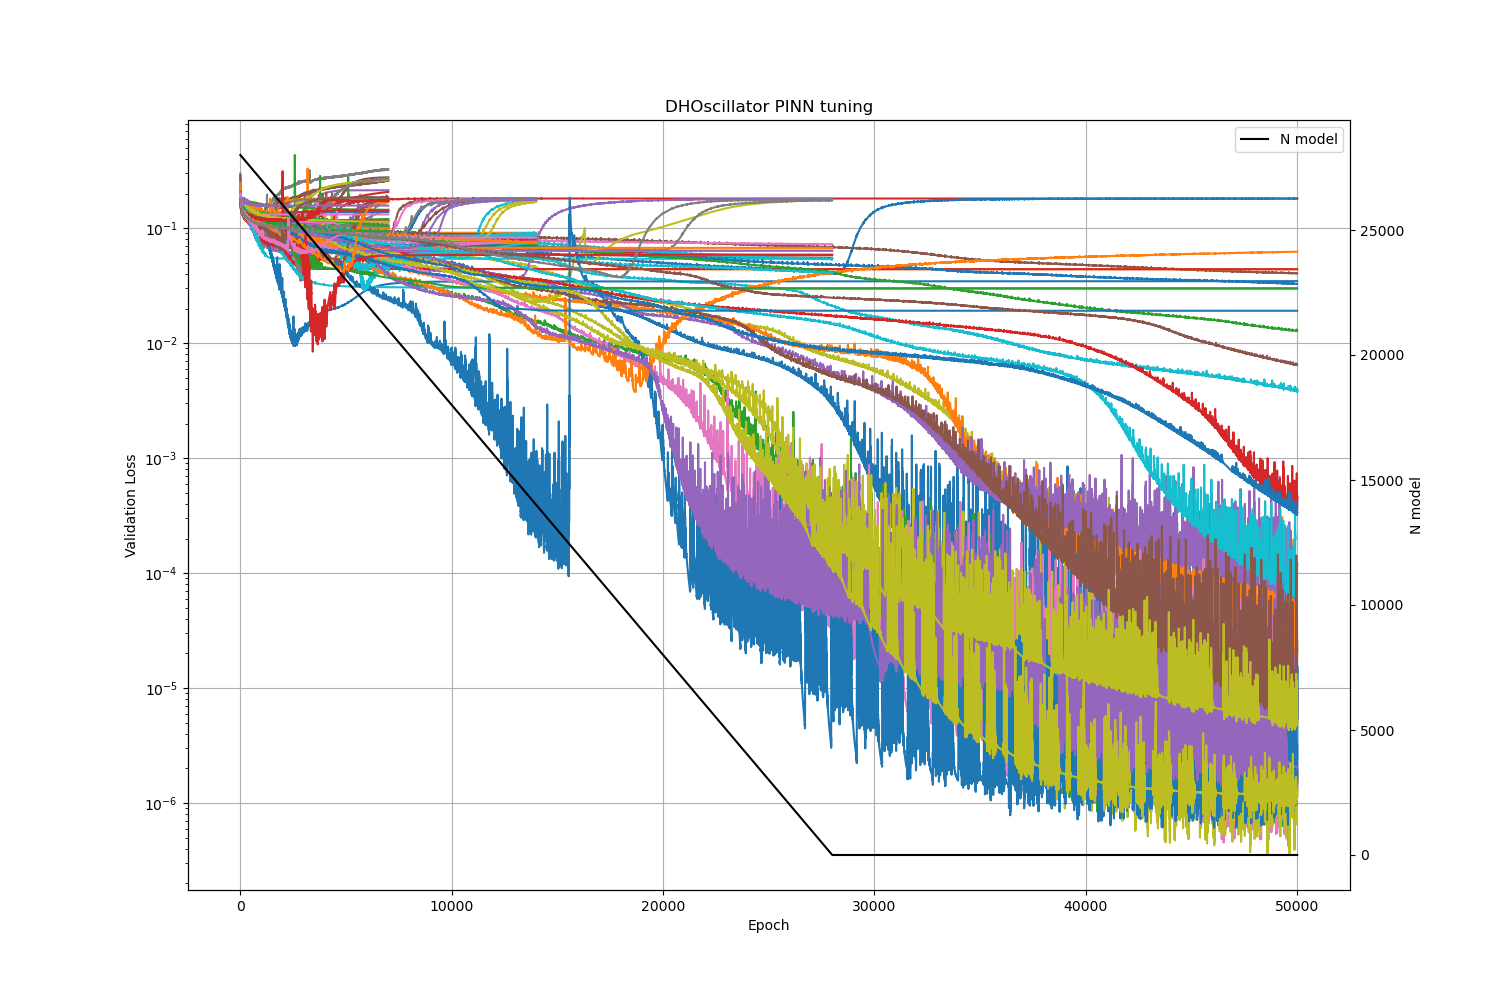

In [18]:
# show results
dfs = {result.path: result.metrics_dataframe for result in results}

# twinx plot alive_model and validation loss
fig, ax1 = plt.subplots(figsize=(15, 10))
# plot the validation loss
for path, df in dfs.items():
    ax1.plot(df["training_iteration"], df["loss"], label=path)
ax1.set_yscale("log")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Validation Loss")
ax1.grid()

# plot the alive model
ax2 = ax1.twinx()
ax2.plot(alive_model, label="N model", color="black")
ax2.set_ylabel("N model")
ax2.legend()
ax2.grid()


plt.title("DHOscillator PINN tuning")
plt.grid()

# save the plot
plt.savefig("../plot/DHOscillator_PINN_tuning.png")


In [19]:
# get best model
best_result = results.get_best_result("loss", mode="min")
logdir = best_result.path
state_dict = torch.load(os.path.join(logdir, "model.pth"))
best_model = FFNN(best_result.config["n_layers"], best_result.config["n_neurons"])

best_model.load_state_dict(state_dict)

# save best model
torch.save(best_model, "../models/DHO_PINN_tuned.pt")

: 

In [13]:
# print validation and test loss
train_X_batches, train_Y_batches, val_X, val_Y, test_X, test_Y = data_loader(
    data_X, 
    data_Y, 
    best_result.config["batch_size"],
    best_result.config["grid_num"]
    )


val_loss = torch.nn.MSELoss()(best_model(val_X), val_Y).item()
test_loss = torch.nn.MSELoss()(best_model(test_X), test_Y).item()

print(f"Validation Loss: {val_loss}")
print(f"Test Loss: {test_loss}")


Validation Loss: 1.239517246176547e-06
Test Loss: 1.7491795460955473e-06


## Restore results

In [14]:
# restore results
experiment_path = os.path.join(results_dir, "DHO_PINN_tuning")
experiment_path

'/home/luigi/Documents/PHYSICS/ML/Project1/src/../tune/DHO_PINN_tuning'

In [15]:
restored_tuner = tune.Tuner.restore(experiment_path, objective)
restored_results = restored_tuner.get_results()

In [16]:
restored_df = restored_results.get_dataframe()
restored_df

loss   timestamp checkpoint_dir_name  done  training_iteration  \
0    0.094820  1710247709                None  True                7000   
1    0.102514  1710247424                None  True                7000   
2    0.000015  1710248027                None  True               50000   
3    0.178123  1710246995                None  True                7000   
4    0.000001  1710248556                None  True               50000   
..        ...         ...                 ...   ...                 ...   
123  0.175027  1710255092                None  True                7000   
124  0.157358  1710255262                None  True                7000   
125  0.185765  1710255140                None  True                7000   
126  0.082898  1710255341                None  True               14000   
127  0.177847  1710255407                None  True               28000   

        trial_id                 date  time_this_iter_s  time_total_s   pid  \
0    9b065_00013  2024-03-12_13-48-29          0.006425     36.962976  5343   
1    9b065_00011  2024-03-12_13-43-44          0.020860    128.469085  5329   
2    9b065_00000  2024-03-12_13-53-47          0.009690    467.900811  5326   
3    9b065_00002  2024-03-12_13-36-35          0.013086    103.356977  5330   
4    9b065_00012  2024-03-12_14-02-36          0.008346    383.581897  5329   
..           ...                  ...               ...           ...   ...   
123  9b065_00123  2024-03-12_15-51-32          0.049581    209.852490  5344   
124  9b065_00124  2024-03-12_15-54-22          0.039076    314.353094  5335   
125  9b065_00125  2024-03-12_15-52-20          0.013357    132.105762  5342   
126  9b065_00126  2024-03-12_15-55-41          0.014910    227.598845  5343   
127  9b065_00127  2024-03-12_15-56-47          0.003831    178.210384  5344   

     ... iterations_since_restore config/n_layers  config/n_neurons  \
0    ...                     7000               2                32   
1    ...                     7000               2                38   
2    ...                    50000               5                33   
3    ...                     7000               3                37   
4    ...                    50000               4                28   
..   ...                      ...             ...               ...   
123  ...                     7000               4                30   
124  ...                     7000               2                28   
125  ...                     7000               5                24   
126  ...                    14000               4                39   
127  ...                    28000               5                27   

     config/lr  config/factor  config/patience  config/batch_size  \
0     0.002414       0.729229              176                541   
1     0.002808       0.869355              123                119   
2     0.001432       0.739127              616                894   
3     0.005881       0.730474              887                118   
4     0.004121       0.749430              618                946   
..         ...            ...              ...                ...   
123   0.002230       0.953331              969                117   
124   0.008645       0.911701              270                115   
125   0.007100       0.810383              223                299   
126   0.007937       0.951226              102                624   
127   0.001029       0.930717              567                520   

     config/grid_num  config/lambda       logdir  
0                329      51.560005  9b065_00013  
1                464      29.381437  9b065_00011  
2                269      81.953152  9b065_00000  
3                121      47.442912  9b065_00002  
4                303      23.923369  9b065_00012  
..               ...            ...          ...  
123              368      16.457702  9b065_00123  
124              998      22.106460  9b065_00124  
125              5